
<blockquote><h3>Анализ зависимости успеха трехочкового броска от таймера в баскетбольных матчах</h3></blockquote>

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

#### Импортируем библиотеки для выгрузки общедоступных данных из google cloud big query

In [2]:
from google.cloud import bigquery
from google.oauth2 import service_account

In [3]:
key_path = 'C:/Users/Da_dk/projects/DataSc_practice/SQL&Pyhton/canvas-advice-393316-e480d1348f71.json'
project_id = 'canvas-advice-393316'
credentials = service_account.Credentials.from_service_account_file(key_path)
client = bigquery.Client(credentials= credentials,project=project_id)

Анализ производится на примере игр команд из первого дивизиона (D1)

#### SQL- запрос к базе данных.
Получим таблицу, в которой будут содержаться значения:
* game_period - отрезок игры (последние 5 минут игры или первые 35)
* threes_made - количество забитых 3-ехочковых мячей
* total_threes - количество 3-ехочковых бросков
* percentile - процент забитых мячей 

In [4]:
query_job = client.query('''
	with start_query as(
                   select  event_type,
                           elapsed_time_sec
                   from    bigquery-public-data.ncaa_basketball.mbb_pbp_sr
                   where   home_division_alias = 'D1' and away_division_alias ='D1' and event_type in ("threepointmade", "threepointmiss")),
             sec         as(
                   select  "first 35 minutes" as game_period,
                           countif(event_type ="threepointmade") as threes_made,
                           countif(event_type ="threepointmade") + countif(event_type ="threepointmiss") as total_threes                    
                   from    start_query
                   where   elapsed_time_sec < 2100

                   union all

                   select  "last 5 minutes" as game_period,
                           countif(event_type ="threepointmade") as threes_made,
                           countif(event_type ="threepointmade") + countif(event_type ="threepointmiss") as total_threes                     
                   from    start_query
                   where   elapsed_time_sec >= 2100),
             third       as(
                   select  *,
                           round(threes_made / total_threes, 2) as percentile
                   from    sec)

        select * from third ''')


In [5]:
df_three = query_job.to_dataframe()

In [6]:
df_three

,game_period,threes_made,total_threes,percentile
0,last 5 minutes,19775,63308,0.31
1,first 35 minutes,132539,377798,0.35


* Как видно, разница между бросками в ходе основной части игры и последними 5 минутами составляет приблизительно 4%. Необходимо проверить, значима ли эта разница.

#### Имеем две гипотезы:
* Нулевая гипотеза: разницы в относительном количестве забиваемых мячей нет
* Алетрнативная гипотеза: Процент забитых мячей в целом больше в ходе первых 35 минут игры
$$H_0: p_0 = p_1$$
$$H_1: p_0 < p_1$$

Гипотезы можно проверить двумя способами:
* Бутстрэп
* АВ-тест

В данном проекте воспользуемся методом бутстрэп

<blockquote><h3>Применение бутстрэп для проверки гипотез</h3></blockquote>

Получим датафрейм с результатами забитых мячей во время матчей в первый период игры - первые 35 минут и в последний период игры - оставшееся время

In [7]:
query1 = client.query('''
      select if (event_type = "threepointmade", 1, 0) as first_period
      from (select   event_type 
            from     bigquery-public-data.ncaa_basketball.mbb_pbp_sr
            where    event_type in ("threepointmade", "threepointmiss") and elapsed_time_sec < 2100
            order by elapsed_time_sec)
''')

query2 = client.query('''
      select if (event_type = "threepointmade", 1, 0) as second_period
      from (select   event_type 
            from     bigquery-public-data.ncaa_basketball.mbb_pbp_sr
            where    event_type in ("threepointmade", "threepointmiss") and elapsed_time_sec >= 2100
            order by elapsed_time_sec)
''')

In [8]:
df_first = query1.to_dataframe()
df_second = query2.to_dataframe()

В результате имеем следующий датафрейм

In [9]:
df_first.head()

,first_period
0,0
1,0
2,1
3,0
4,0


In [10]:
df_second.head()

,second_period
0,0
1,0
2,0
3,0
4,1


Фактическая разница забитых мячей в долях:

In [11]:
p_diff_fact = abs(df_first.first_period.sum() / df_first.first_period.size -  df_second.second_period.sum() / df_second.second_period.size)
p_diff_fact

0.038054291139455465

Зададим количество создаваемых в процессе бутстрэпа выборок

In [12]:
num_boot = 1500
p_diffs = []

Вычислим разницу забитых мячей в долях между создаваемыми выборками

In [13]:
for _ in range(num_boot):
    first_period_boot = np.random.choice(df_first.first_period, df_first.first_period.size, True) # создаем выборки для первых 35 минут игры
    second_period_boot = np.random.choice(df_second.second_period, df_second.second_period.size, True) # создаем выборки для оставшегося времени
    p_diff = second_period_boot.sum() / second_period_boot.size - first_period_boot.sum() / first_period_boot.size
    p_diffs.append(p_diff)

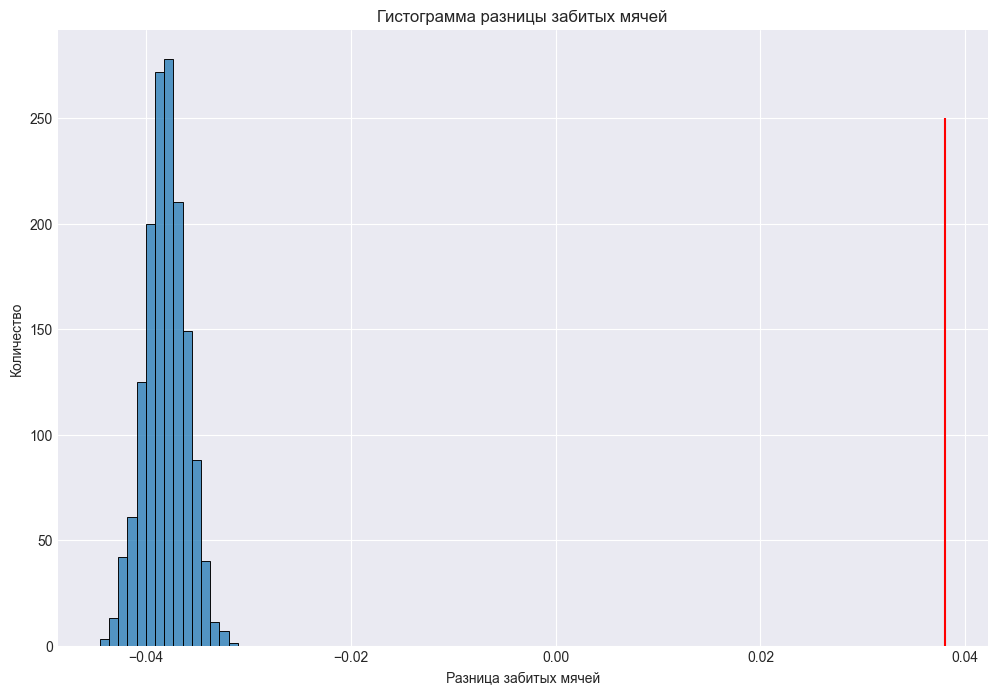

In [14]:
plt.figure(figsize=(12, 8))
plt.vlines(x=[p_diff_fact], ymin=[0], ymax=[250], colors=['red'])
plt.title('Гистограмма разницы забитых мячей')
sns.histplot(p_diffs, bins=15)
plt.xlabel('Разница забитых мячей')
plt.ylabel('Количество')
plt.show()

Центрируем относительно нуля значения выборки

In [15]:
p_diffs = np.array(p_diffs)
p_diffs_cent = p_diffs - p_diffs.mean()

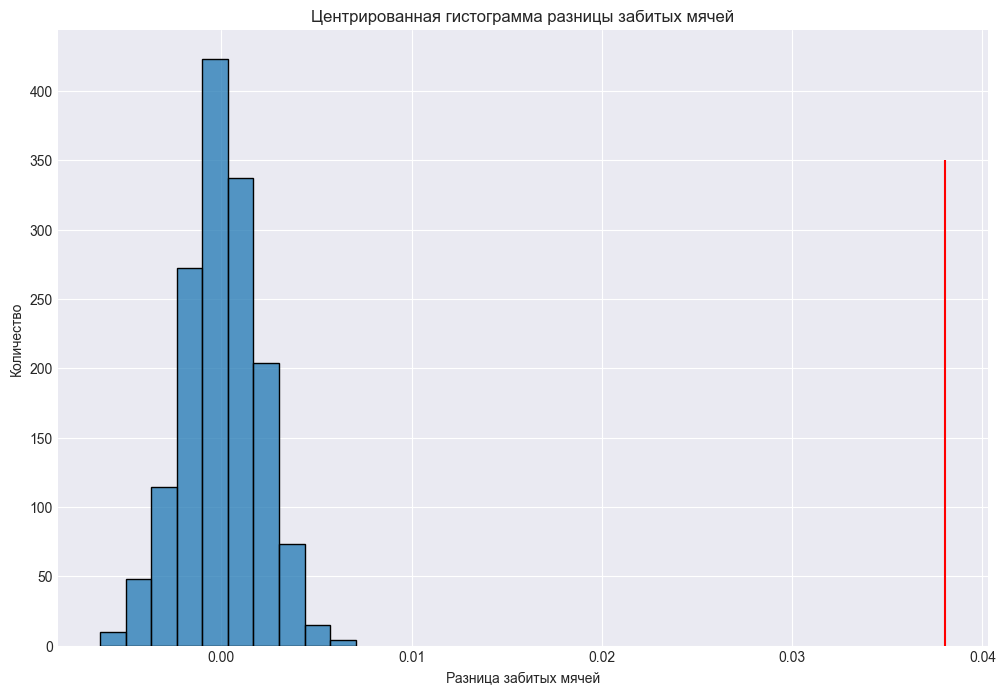

In [16]:
plt.figure(figsize=(12, 8))
plt.vlines(x=[p_diff_fact], ymin=[0], ymax=[350], colors=['red'])
plt.title('Центрированная гистограмма разницы забитых мячей')
sns.histplot(p_diffs_cent, bins=10)
plt.xlabel('Разница забитых мячей')
plt.ylabel('Количество')
plt.show()

In [17]:
p_value = sum(p_diffs_cent >= p_diff_fact) / num_boot
p_value

0.0

In [18]:
alpha = 0.05
result = f'Нулевая гипотеза принимается на {int(alpha*100)}% уровне значимости' if p_value > alpha \
    else f'Нулевая гипотеза отклоняется на {int(alpha*100)}% уровне значимости'
result

'Нулевая гипотеза отклоняется на 5% уровне значимости'

<blockquote><h3>Вывод</h3></blockquote>
<p style="margin-left: 50px; margin-bottom: 1px; margin-top: 10px;">

* Нулевая гипотеза была отвергнута на 5% уровне значимости (на любом другом уровне значимости нулевая гипотеза тоже была бы отвергнута)</p>
<p style="margin-left: 50px; margin-bottom: 1px; margin-top: 10px;">

* Принята альтернативная гипотеза - процент забитых мячей в целом больше в ходе первых 35 минут игры</p>